# Recommendation of products using Amazon data

This project will be recommending the products based on one specific product selected. And to work on this I gathered data from the Amazon API. However, seeing that the data is huge, I chose to work with a subset of data consisting of women tops only. The most attributes would be the brand, color, product type, image, and title. So, taking only these into consideration from the data mart and it was stored locally in the form of pickle which will be used for further data processing.

Real life scenarios use a combination of multiple methods like context based and collaborative filtering for recommending from the data. For context-based, a combination of different algorithms is used for better performance. In this project, TF-IDF weighted word2vec will be used for the title of the product and Weighted similarity for other features as the brand, color, product type. And for collaborative filtering, we will require the data of previous customers who have visited the page for the said product while shopping and were interested in which other products. Since we do not have access to user-related data in Amazon, we will not be using collaborative filtering this project.

Testing:
In real life, the methods like A|B testing are used to determine the efficiency of the recommendations given. Owing to access restrictions to Amazon customer data, the recommendations given by the system will have to be manually analyzed to look for relevance. Weights will be adjusted to obtain an even more accurate result.

In [137]:
#import all the required documents
import pandas as pd
from texttable import Texttable
import nltk
from nltk.corpus import stopwords
import itertools
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import Counter
import seaborn as sns
import requests
from PIL import Image
from io import BytesIO
import time

In [138]:
data = pd.read_pickle('product_data') #read the pickled data and store in the data variable as a data frame
data.head(2) #prints the top 2 rows of the data frame

,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None


1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to )
3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)

## Understanding the data in hand:

- Need to convert the column name to camel casing (personal preference).

In [139]:
print(data.columns) 
#renaming the data frame columns
data.rename(columns={'asin':'Asin', 'brand':'Brand', 'color':'Color','medium_image_url':'MediumImageUrl', 
                     'product_type_name': 'ProductTypeName','title':'Title', 'formatted_price':'FormattedPrice'}, inplace=True)
print(data.columns)

Index(['asin', 'brand', 'color', 'medium_image_url', 'product_type_name',
       'title', 'formatted_price'],
      dtype='object')
Index(['Asin', 'Brand', 'Color', 'MediumImageUrl', 'ProductTypeName', 'Title',
       'FormattedPrice'],
      dtype='object')


In [140]:
print ('Number of data points : ', data.shape[0])
print('Number of features/variables:', data.shape[1])

Number of data points :  183138
Number of features/variables: 7


In [141]:
# Stats for all features in the data and the data type of the data columns in the data frame 
descriptionTable = Texttable()
descriptionTable.add_rows([['data description table', '-','--'],\
            [data['Asin'].describe(), data['Brand'].describe(), data['Color'].describe()],\
            [data['MediumImageUrl'].describe(), data['ProductTypeName'].describe(), data['Title'].describe()],\
            [data['FormattedPrice'].describe(), '--', '--']])
print(descriptionTable.draw())

+--------------------------+-------------------------+-------------------------+
|  data description table  |            -            |           --            |
+==========================+=========================+=========================+
| count         183138     | count     182987        | count     64956         |
| unique        183138     | unique     10577        | unique     7380         |
| top       B01LJEY5OC     | top         Zago        | top       Black         |
| freq               1     | freq         223        | freq      13207         |
| Name: Asin, dtype:       | Name: Brand, dtype:     | Name: Color, dtype:     |
| object                   | object                  | object                  |
+--------------------------+-------------------------+-------------------------+
| count                    | count     183138        | count                   |
| 183138                   | unique        72        | 183138                  |
| unique                   |

### observations

- All the Asin are unique.
- Title is not unique as well. But this is expected to be unique as this will be one of the key feature based on which we will recommend. So must observe this data points as to who they are same, is it intentional or is it an error.
- Images are not unique. So there are multiple products that are using the same image.
- The data type of all the columns including the Formatted Price are in the data type of object.
- There are 7380 different Color (wow).

In [142]:
print(data['Color'].unique()) #River Rock Acid Wash, Onyx Black/ Stone is a color ???

[None 'Onyx Black/ Stone' 'Grape' ..., 'Combo C'
 'White, Soft Coral and Charcoal Varigated' 'Monochrome Plaid']


In [143]:
print(data[data['Title'] == data['Title'].value_counts().index[2]].head(5))

             Asin     Brand      Color  \
67561  B01HAAYQLQ  Jooniyaa        Red   
71332  B01HAAZMGO  Jooniyaa  Black New   
74371  B01HAAYRZ6  Jooniyaa        Red   
75222  B01HAAYXWI  Jooniyaa  Navy Blue   
75444  B01H3YWENG  Jooniyaa      Black   

                                          MediumImageUrl ProductTypeName  \
67561  https://images-na.ssl-images-amazon.com/images...           SHIRT   
71332  https://images-na.ssl-images-amazon.com/images...           SHIRT   
74371  https://images-na.ssl-images-amazon.com/images...           SHIRT   
75222  https://images-na.ssl-images-amazon.com/images...           SHIRT   
75444  https://images-na.ssl-images-amazon.com/images...           SHIRT   

                                                   Title FormattedPrice  
67561  FINEJO Casual Women Long Sleeve Lace Irregular...         $19.97  
71332  FINEJO Casual Women Long Sleeve Lace Irregular...         $19.92  
74371  FINEJO Casual Women Long Sleeve Lace Irregular...         $19

### observations

- On observing the titles in Amazon website it is the same shirt but with a variation in color.
- When we recommend the products it must be similar products not the same product so the duplicates can be removed.
- i.e, a single title record will be saved and others can be deleted from the data frames.


## Data cleaning:

### Removing null data records with null values

- As we are about to consider the Image, Title, Cost, Color, Brand and Formatted price they must be not null values. 

In [144]:
data.columns

Index(['Asin', 'Brand', 'Color', 'MediumImageUrl', 'ProductTypeName', 'Title',
       'FormattedPrice'],
      dtype='object')

In [145]:
print(data.shape[0])
data = data.loc[~data['Brand'].isnull()]
print('Number of data points after removing Brand = NULL :', data.shape[0])
data = data.loc[~data['Color'].isnull()]
print('Number of data points after removing Color = NULL :', data.shape[0])
data = data.loc[~data['MediumImageUrl'].isnull()]
print('Number of data points after removing Medium image url = NULL :', data.shape[0])
data = data.loc[~data['Title'].isnull()]
print('Number of data points after removing Title = NULL :', data.shape[0])
data = data.loc[~data['FormattedPrice'].isnull()]
print('Number of data points after removing Formatted price=NULL :', data.shape[0])

183138
Number of data points after removing Brand = NULL : 182987
Number of data points after removing Color = NULL : 64843
Number of data points after removing Medium image url = NULL : 64843
Number of data points after removing Title = NULL : 64843
Number of data points after removing Formatted price=NULL : 28292


### observations

- The null values existed in the brand, color, formatted price.
- The data size decreased drastically.

### Stop word removal for the title's in the data frame

In [146]:
stopWordsList = set(stopwords.words('english'))
print ('list of stop words are:', stopWordsList)

list of stop words are: {'me', 'couldn', 'y', 'again', 'having', 'further', 'm', 'll', 'doesn', 'am', 'now', 'because', 'other', 'this', 'her', 'nor', 'on', 'hers', 'but', 'herself', 'has', 'were', 'when', 'an', 'for', 'these', 'yours', 'if', 'until', 'you', 'was', 'then', 'doing', 'do', 'our', 'how', 'as', 'ma', 'mustn', 'all', 'the', 'about', 'its', 'shan', 'wasn', 'in', 'does', 'into', 'with', 'be', 'both', 'itself', 'which', 'here', 'whom', 'ourselves', 'no', 'haven', 'weren', 'some', 'where', 'can', 'aren', 'between', 'after', 'mightn', 'my', 'will', 'what', 'o', 'against', 'shouldn', 'few', 'is', 'don', 'have', 'a', 'from', 'very', 'to', 'hadn', 'his', 'more', 've', 'any', 'most', 'their', 'and', 'it', 'just', 't', 'should', 'such', 'of', 'myself', 'under', 'she', 'not', 'hasn', 'ain', 'why', 'd', 'once', 'he', 'that', 'only', 'or', 'being', 'own', 'those', 'through', 'each', 'there', 'yourselves', 'themselves', 'up', 'isn', 'needn', 'been', 're', 'out', 'too', 'same', 'won', 'hi

In [147]:
data['Title'][135865]

"woman's place is in the house and the senate shirts for Womens XXL White"

In [148]:
data['Title'] = data['Title'].str.lower()
data['Brand'] = data['Brand'].str.lower()
data['Color'] = data['Color'].str.lower()
#convert the text data into lower case.

In [149]:
def stopWordRemoval(totalText, index, column):
    if type(totalText) is str:
        string = ""
        for words in totalText.split():
            word = ("".join(e for e in words if e.isalnum())) # remove the special chars
            if not word in stopWordsList:
                string += word + " "
        data[column][index] = string

In [150]:
for index, dataRow in data.iterrows():
    stopWordRemoval(dataRow['Title'], index, 'Title')

In [151]:
data['Title'][135865]

'womans place house senate shirts womens xxl white '

In [152]:
data.shape[0]

28292

- The title is changed to lower case and removed the stop words.

### Deduping the data

- As observed earlier the Titles are duplicate so removed them by storing first element.

In [153]:
print("Before deduping data", sum(data.duplicated('Title'))) #data elements with duplicate titles 
data =data.drop_duplicates(subset='Title', keep="first")
print("duplicate data", sum(data.duplicated('Title')))
print(data.shape[0])
data.head(3)

Before deduping data 3011
duplicate data 0
25281


,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
4,B004GSI2OS,featherlite,onyx black/ stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,hx-kingdom fashion t-shirts,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
11,B001LOUGE4,fitness etc.,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies cotton tank 2x1 ribbed tank top,$11.99


In [154]:
print(data.shape[0])
data.head(3)

25281


,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
4,B004GSI2OS,featherlite,onyx black/ stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,hx-kingdom fashion t-shirts,white,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
11,B001LOUGE4,fitness etc.,black,https://images-na.ssl-images-amazon.com/images...,SHIRT,ladies cotton tank 2x1 ribbed tank top,$11.99


- Having a short data title is not useful so making sure that the data title is a min of 4 words and sort the titles alphabetically.

In [155]:
# Remove products with title less than 4 words
print("Before removal of products with short description:", data.shape[0])
daata = data[data['Title'].apply(lambda title: len(title.split())>4)]
print("After removal of products with short description:", data.shape[0])
# Sort the whole data based on title (alphabetical order of title) 
data.sort_values('Title',inplace=True, ascending=False)
data.head(2)

Before removal of products with short description: 25281
After removal of products with short description: 25281


,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
61973,B06Y1KZ2WB,éclair,black/pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,éclair womens printed thin strap blouse black ...,$24.99
87998,B01DJ409WM,zuric,multicolored,https://images-na.ssl-images-amazon.com/images...,SHIRT,zuric world map shirt print cute short sleeves...,$15.00


#### Some titles differ only in the last few words.

Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt

In [156]:
indices = []
for i,row in data.iterrows():
    indices.append(i)

- If the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them

In [157]:
uniqueTitleAsins = []
i = 0
j = 0
dataPointsSize = data.shape[0]
while i < dataPointsSize and j < dataPointsSize:
    prevIndex = i
    # search for the similar products sequentially 
    titleWords = data['Title'].loc[indices[i]].split()
    j = i+1
    while j < dataPointsSize:
        otherTitleWords = data['Title'].loc[indices[j]].split()

        maxLengthOfTwoStrings = max(len(titleWords), len(otherTitleWords))
        noOfWordsThatAreMatched = 0
        for k in itertools.zip_longest(titleWords,otherTitleWords): 
            if (k[0] == k[1]):
                noOfWordsThatAreMatched += 1
        if (maxLengthOfTwoStrings - noOfWordsThatAreMatched) > 2: 
            uniqueTitleAsins.append(data['Asin'].loc[indices[i]])
            if j == dataPointsSize-1: 
                uniqueTitleAsins.append(data['Asin'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if prevIndex == i:
        break

In [158]:
data = data.loc[data['Asin'].isin(uniqueTitleAsins)]

In [159]:
data.head(2)

,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
61973,B06Y1KZ2WB,éclair,black/pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,éclair womens printed thin strap blouse black ...,$24.99
87998,B01DJ409WM,zuric,multicolored,https://images-na.ssl-images-amazon.com/images...,SHIRT,zuric world map shirt print cute short sleeves...,$15.00


### observations

- Index not even after data cleaning, so must reindex the data frame.

In [160]:
data = data.reset_index(drop=True)
data.head(2)

,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
0,B06Y1KZ2WB,éclair,black/pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,éclair womens printed thin strap blouse black ...,$24.99
1,B01DJ409WM,zuric,multicolored,https://images-na.ssl-images-amazon.com/images...,SHIRT,zuric world map shirt print cute short sleeves...,$15.00


In [161]:
#data.to_pickle('data_preprocessed')

# Utility functions for the recommending the product

In [162]:
def displayImage(url):
    '''
    By using the Basic Stream I/O (BytesIO) Fetching the Image from the URL and disaplying It in the plt.
    '''    
    print(url)
    img = Image.open(BytesIO(requests.get(url).content))
    plt.imshow(img)

In [163]:
def plotHeatmap(itemIndex, text1Vector, text2Vector, heatmapTitle):
    '''
    Creates a heat map, and fetch the tf - idf values for the text.
    '''
    intersection = set(text1Vector.keys()) & set(text2Vector.keys())
    for i in text2Vector:
        if i not in intersection:
            text2Vector[i]=0

    words = list(text2Vector.keys())
    wordCount = [text2Vector[x] for x in text2Vector.keys()]
    labels = []
    for x in text2Vector.keys():
        if x in  tfidfTitleVectorizer.vocabulary_:
            labels.append(tfidfTitleFeatures[itemIndex, tfidfTitleVectorizer.vocabulary_[x]])
        else:
            labels.append(0)
    
    fig = plt.figure(figsize=(25,3))
    ax = sns.heatmap(np.array([wordCount]), annot=np.array([labels]))
    ax.set_xticklabels(words) 
    ax.set_title(heatmapTitle)
    
    plt.show()

In [164]:
def textToVector(text):
    '''
    Creates a dictionary key as words in text with its corresponding count.
    '''
    wordsList = re.findall(r'\w+',text)
    return Counter(wordsList) 

In [165]:
def displayResult(itemIndex, text1, text2):
    '''
    Convert the text to vector and diasply the results
    '''
    plotHeatmap(itemIndex, textToVector(text1), textToVector(text2), text2)

In [166]:
def displayProductDetails(data, itemIndex):
    '''
    Prints all the product related details.
    '''
    asinData = data.iloc[itemIndex]
    print('Title :',asinData['Title'])
    print('ASIN :',asinData['Asin'])
    print('BRAND :',asinData['Brand'])
    print('Color :',asinData['Color'])
    print('Type :',asinData['ProductTypeName'])
    print('_'*120)
    print('_'*120)

## TF-IDF word to vec for recommendation

I am using a pretrained model by google it occupies ~9Gb, the data is pickled and in the form of a dictionary, and it contains all corpus words as keys and model [word] as values. The text vector is fetched from "GoogleNews-vectors-negative300.bin".

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

In [167]:
import pickle
with open('word2vec', 'rb') as handle:
    model = pickle.load(handle)

In [168]:
vocab = model.keys() #stores all the words that are there in google w2v model

def weightedWord2vecTitleWeight(title, word2vecVectorLenght, itemIndex):
    featureVec = np.zeros((word2vecVectorLenght,), dtype="float32")
    wordCount = 0
    for word in title.split():
        wordCount += 1
        if word in vocab and len(word) >2:
            try:
                featureVec = np.add(featureVec, tfidfTitleFeatures[itemIndex, tfidfTitleVectorizer.vocabulary_[word]] * model[word])
            except IndexError:
                featureVec = np.add(featureVec, 0 * model[word])
    if(wordCount > 0):
        featureVec = np.divide(featureVec, wordCount)
    return featureVec

In [169]:
def weightedTfIdfWord2vec(itemIndex, numberOfRecommendations, textWeight, brandWeight, typeWeight, colorWeight):
    
    try:
        tfidfWord2vecDist = pairwise_distances(word2vecTitleWeight,word2vecTitleWeight[itemIndex].reshape(1,-1))
        brandFeauresDist = pairwise_distances(brandFeatures, brandFeatures[itemIndex])
        typeFeauresDist = pairwise_distances(typeFeatures, typeFeatures[itemIndex])
        colorFeauresDist = pairwise_distances(colorFeatures, colorFeatures[itemIndex])
        pairwiseDisances   = ((textWeight * tfidfWord2vecDist) +  (brandWeight * brandFeauresDist)\
                              +(typeWeight * typeFeauresDist) + (colorWeight * colorFeauresDist))\
                             /float(textWeight + brandWeight + typeWeight + colorWeight)
    except IndexError:
        pairwiseDisances = [ 0 * tfidfTitleFeatures[0]]

    indices = np.argsort(pairwiseDisances.flatten())[0:numberOfRecommendations]
    pdists  = np.sort(pairwiseDisances.flatten())[0:numberOfRecommendations]

    dataFrameIndices = list(data.index[indices])
    for index in range(0,len(indices)):
        displayImage(data['MediumImageUrl'].loc[dataFrameIndices[index]])
        displayResult(indices[index], data['Title'].loc[dataFrameIndices[0]],data['Title'].loc[dataFrameIndices[index]])
        print('ASIN :',data['Asin'].loc[dataFrameIndices[index]])
        print('Brand :',data['Brand'].loc[dataFrameIndices[index]])
        print('Color :',data['Color'].loc[dataFrameIndices[index]])
        print('Type :',data['ProductTypeName'].loc[dataFrameIndices[index]])
        print('euclidean distance from input :', pdists[index])
        print('_'*120)

In [170]:
brandList = [x.replace(" ", "-") for x in data['Brand'].values]
typeList = [x.replace(" ", "-") for x in data['ProductTypeName'].values]
colorList = [x.replace(" ", "-") for x in data['Color'].values] 

brandFeatures = CountVectorizer().fit_transform(brandList)
typeFeatures = CountVectorizer().fit_transform(typeList)
colorFeatures = CountVectorizer().fit_transform(colorList)

## End result (lets Recommend)

In [171]:
itemId = 229
itemIndex = itemId
numberOfRecommendations = 10

Each feature is assigned with a particular weight and the recommendations are done based on it

In [172]:
textWeight = 25
brandWeight = 15
typeWeight = 10
colorWeight = 5

In [173]:
data.head()

,Asin,Brand,Color,MediumImageUrl,ProductTypeName,Title,FormattedPrice
0,B06Y1KZ2WB,éclair,black/pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,éclair womens printed thin strap blouse black ...,$24.99
1,B01DJ409WM,zuric,multicolored,https://images-na.ssl-images-amazon.com/images...,SHIRT,zuric world map shirt print cute short sleeves...,$15.00
2,B06Y1QL93D,zumeet,pink,https://images-na.ssl-images-amazon.com/images...,SHIRT,zumeet women plus size loose waist shirt blous...,$79.99
3,B073RRLKDG,zumba,dance l orange,https://images-na.ssl-images-amazon.com/images...,SHIRT,zumba unisex exclusiveworld tour flannel shirt...,$25.50
4,B071VM4DLN,zumba,blue,https://images-na.ssl-images-amazon.com/images...,SHIRT,zumba unisex convention exclusive studded flan...,$22.50


In [174]:
word2vecTitleWeight = []
tfidfTitleVectorizer = TfidfVectorizer(min_df = 0)
tfidfTitleFeatures = tfidfTitleVectorizer.fit_transform(data['Title'])
for title in data['Title']:
    word2vecTitleWeight.append(weightedWord2vecTitleWeight(title, 300, itemId))
    itemId += 1
word2vecTitleWeight = np.array(word2vecTitleWeight)

Title : yichun women girls thin tshirt tops batwing sleeve tees tunic casual cami hand v 8 
ASIN : B01IA58OZY
BRAND : yichun
Color : hand v 8#
Type : BOOKS_1973_AND_LATER
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41OCDJZ52jL._SL160_.jpg


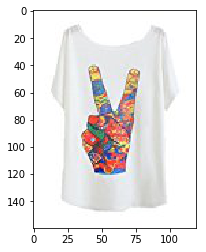

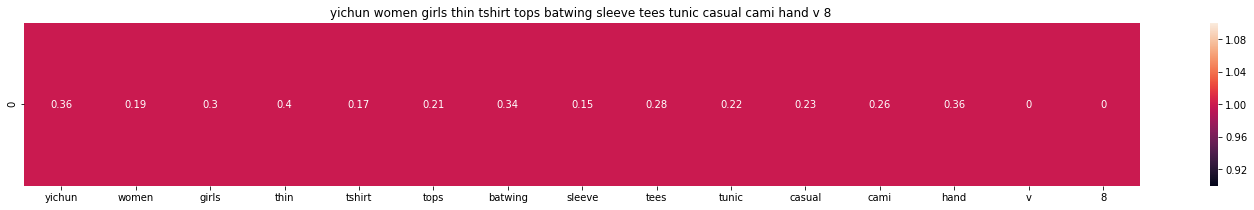

ASIN : B01IA58OZY
Brand : yichun
Color : hand v 8#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.0
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/31fDyjgYjlL._SL160_.jpg


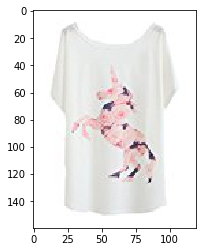

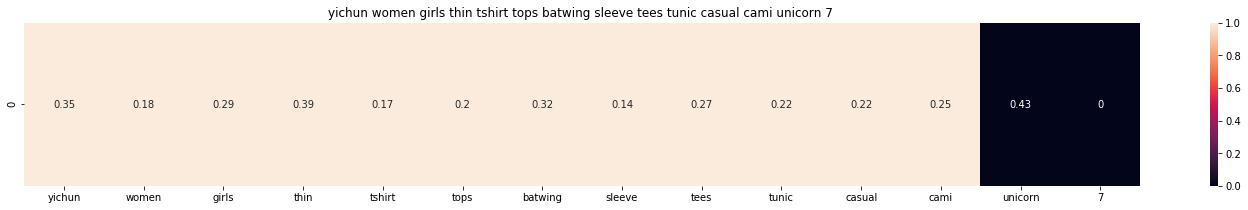

ASIN : B01IA58P3K
Brand : yichun
Color : unicorn 7#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41PpWvLUNYL._SL160_.jpg


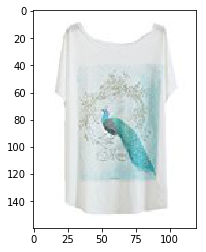

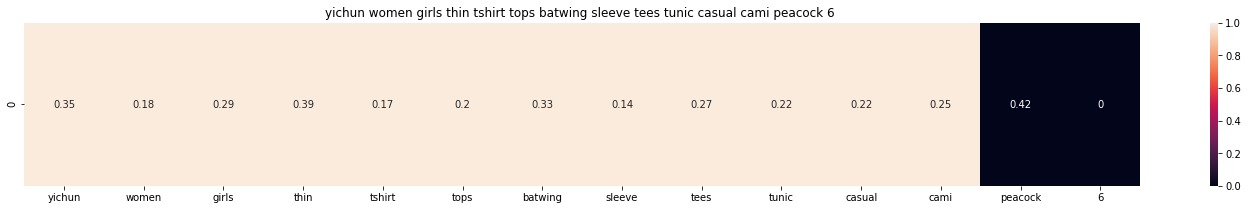

ASIN : B01IA58P3U
Brand : yichun
Color : peacock 6#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41nqh6FOJEL._SL160_.jpg


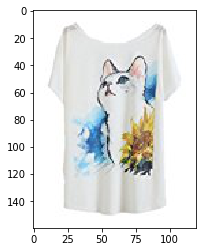

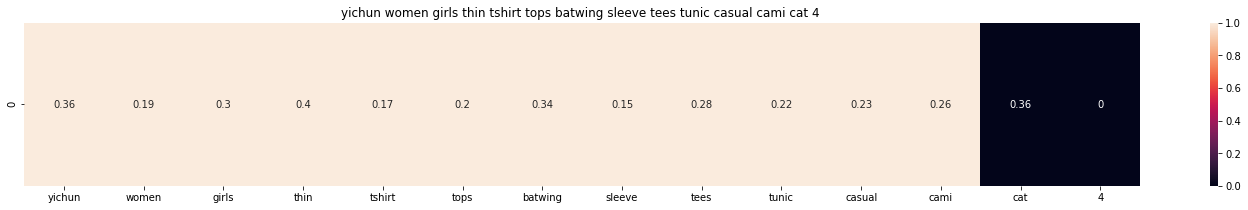

ASIN : B01IA58P8K
Brand : yichun
Color : cat 4#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41MWxcBNDZL._SL160_.jpg


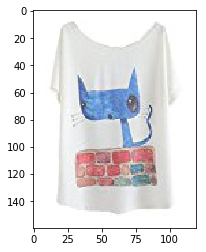

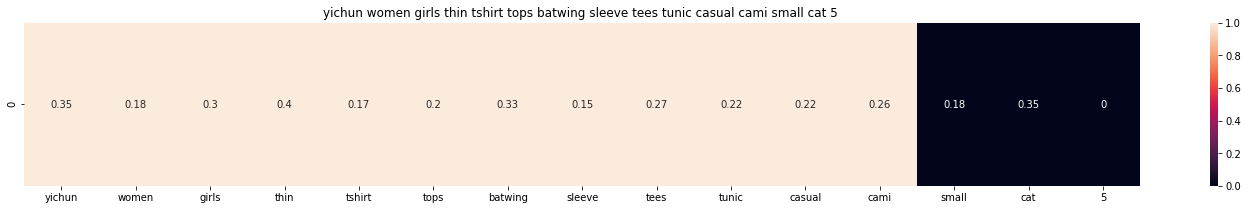

ASIN : B01IA58P6C
Brand : yichun
Color : small cat 5#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.157459164324
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41wdy1DH1cL._SL160_.jpg


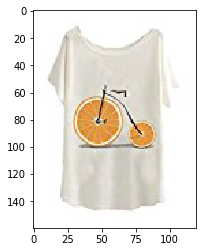

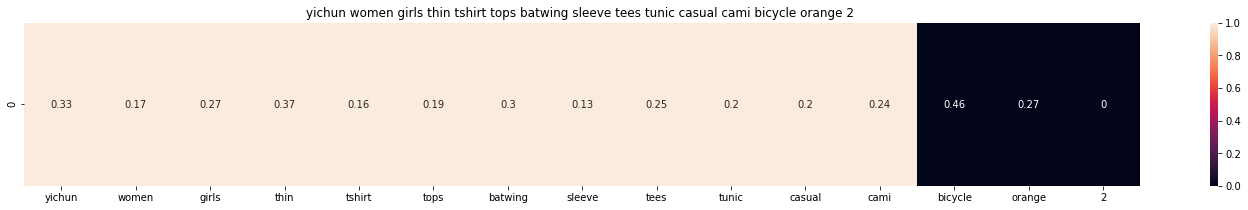

ASIN : B01IA58P30
Brand : yichun
Color : bicycle orange 2#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.157459164324
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41G13IMbF3L._SL160_.jpg


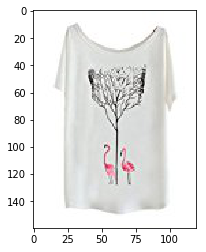

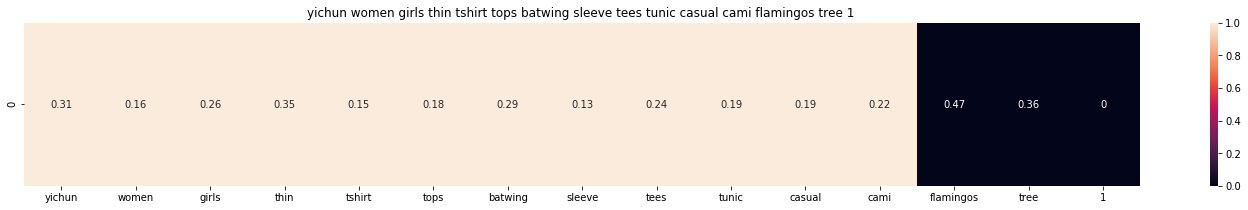

ASIN : B01IA58P8U
Brand : yichun
Color : flamingos tree 1#
Type : BOOKS_1973_AND_LATER
euclidean distance from input : 0.172171740757
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/410gqMmLojL._SL160_.jpg


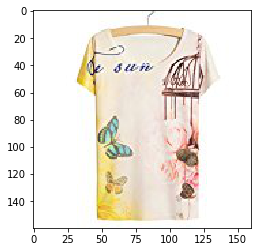

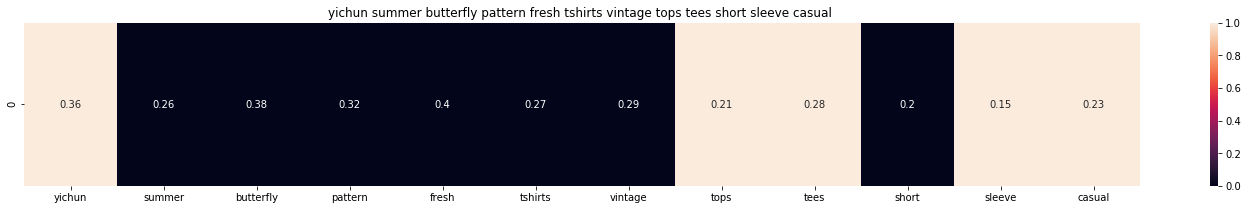

ASIN : B010NN9X5Q
Brand : yichun
Color : multicoloured
Type : SHIRT
euclidean distance from input : 0.38569460792
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/513IYzMyzrL._SL160_.jpg


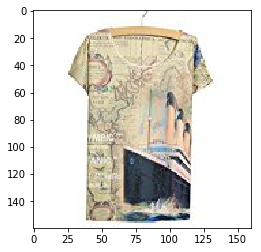

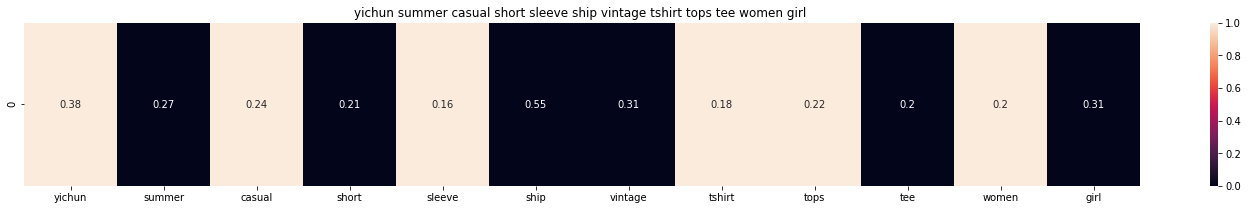

ASIN : B010NN9UMM
Brand : yichun
Color : multicoloured
Type : SHIRT
euclidean distance from input : 0.38569460792
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41TgybFBqtL._SL160_.jpg


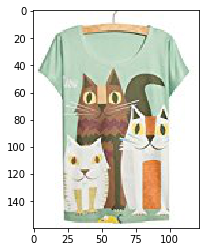

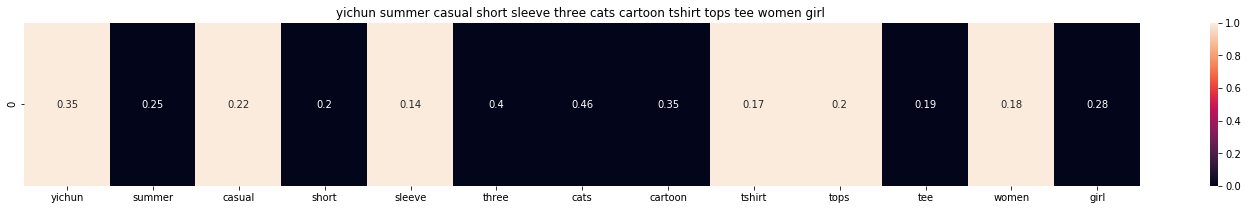

ASIN : B011VF95SK
Brand : yichun
Color : multicoloured
Type : SHIRT
euclidean distance from input : 0.38569460792
________________________________________________________________________________________________________________________


In [175]:
displayProductDetails(data, itemIndex) #display the product details for which the recommendations are provided
weightedTfIdfWord2vec(itemIndex, numberOfRecommendations, textWeight, brandWeight, typeWeight, colorWeight)

### One more product 

To test if the weights that are assigned to the feature are appropriate they must be tested with more than one product so another product is considered

In [180]:
itemId = 1368
itemIndex = itemId
numberOfRecommendations = 10

In [181]:
textWeight = 25
brandWeight = 15
typeWeight = 10
colorWeight = 5

In [182]:
word2vecTitleWeight = []
tfidfTitleVectorizer = TfidfVectorizer(min_df = 0)
tfidfTitleFeatures = tfidfTitleVectorizer.fit_transform(data['Title'])
for title in data['Title']:
    word2vecTitleWeight.append(weightedWord2vecTitleWeight(title, 300, itemId))
    itemId += 1
word2vecTitleWeight = np.array(word2vecTitleWeight)

Title : women summer fashion tshirt colorful yummy donuts short sleeve crop top 
ASIN : B011LD2IA4
BRAND : mkp t-shirt
Color : black, white, brown
Type : SHIRT
________________________________________________________________________________________________________________________
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41PEzMP691L._SL160_.jpg


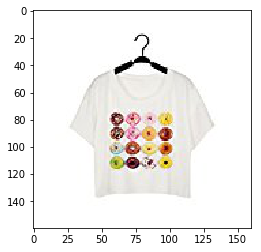

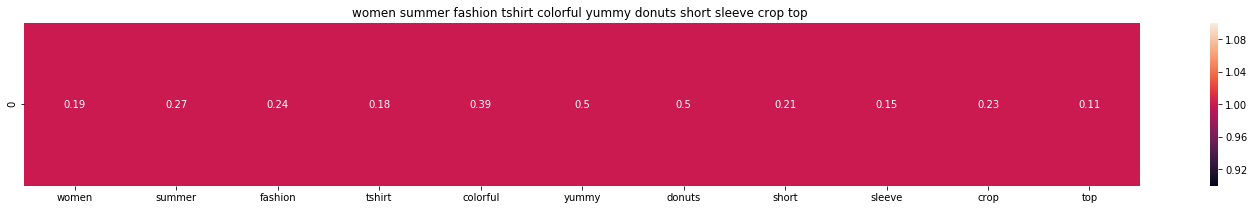

ASIN : B011LD2IA4
Brand : mkp t-shirt
Color : black, white, brown
Type : SHIRT
euclidean distance from input : 0.0
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41dn-2n8YkL._SL160_.jpg


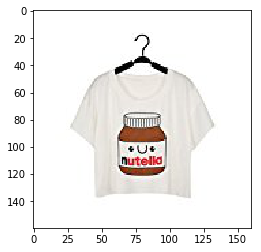

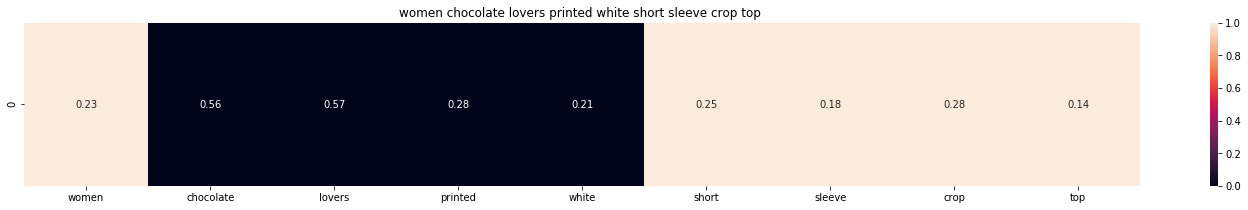

ASIN : B01MSX4JF1
Brand : mkp t-shirt
Color : black, white, brown, red
Type : SHIRT
euclidean distance from input : 0.0909090909091
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41YooA5okrL._SL160_.jpg


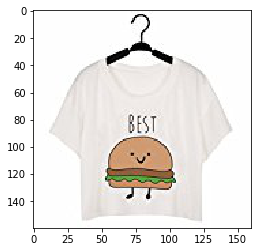

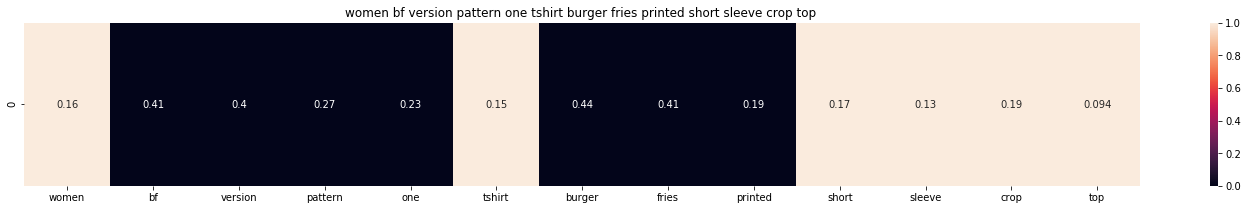

ASIN : B01NGTWQXM
Brand : mkp t-shirt
Color : black, white, brown, green
Type : SHIRT
euclidean distance from input : 0.0909090909091
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/51YPkGTQVwL._SL160_.jpg


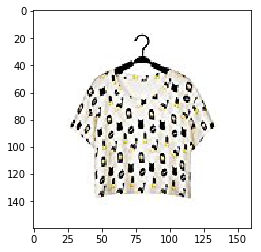

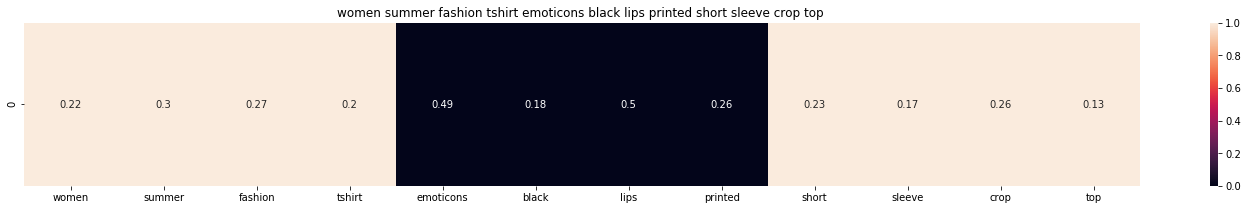

ASIN : B010KA97QC
Brand : mkp t-shirt
Color : black, white, yellow
Type : SHIRT
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41JI8EZlhgL._SL160_.jpg


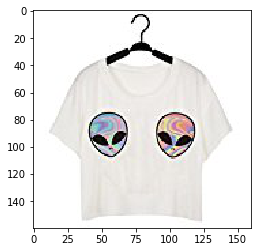

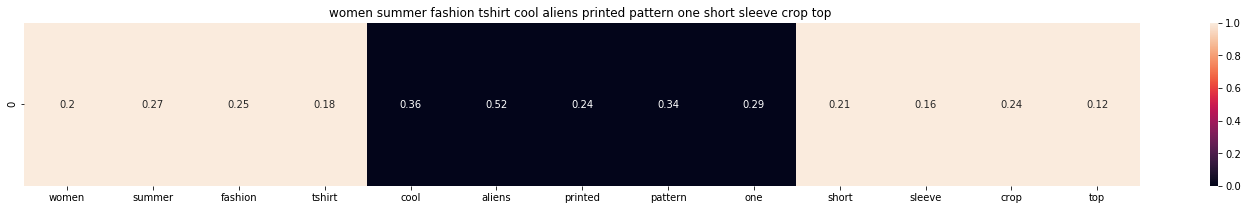

ASIN : B01JIBDBH0
Brand : mkp t-shirt
Color : black, white, gray
Type : SHIRT
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41Vn8%2BsHz3L._SL160_.jpg


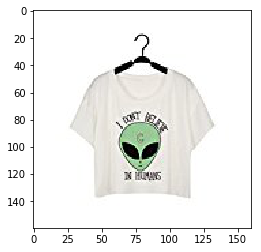

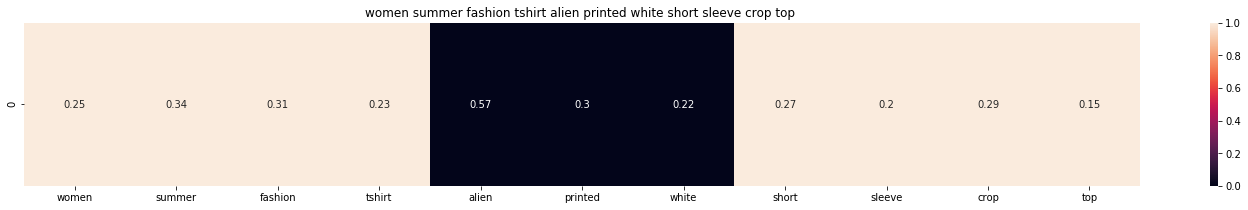

ASIN : B011LCU1ZE
Brand : mkp t-shirt
Color : black, white, green
Type : SHIRT
euclidean distance from input : 0.128564869307
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41VGtI0wHGL._SL160_.jpg


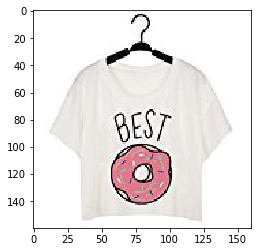

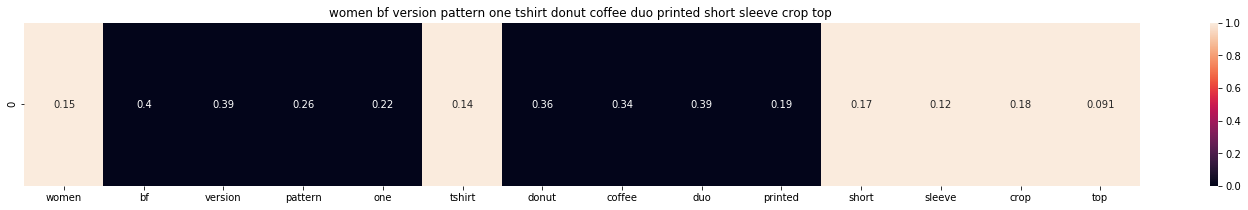

ASIN : B01MRUVC1U
Brand : mkp t-shirt
Color : black, white, pink, blue
Type : SHIRT
euclidean distance from input : 0.157459164324
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41xxVHa-XkL._SL160_.jpg


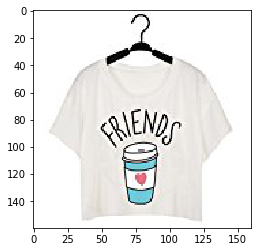

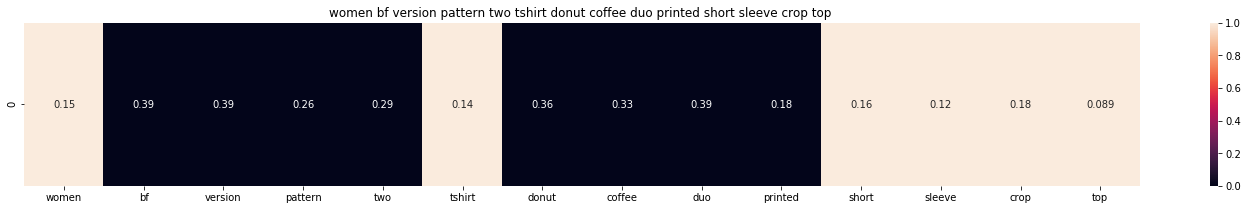

ASIN : B01N4BDAC0
Brand : mkp t-shirt
Color : black, white, pink, blue
Type : SHIRT
euclidean distance from input : 0.157459164324
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41ayl2oI92L._SL160_.jpg


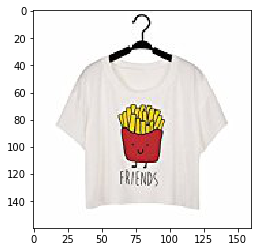

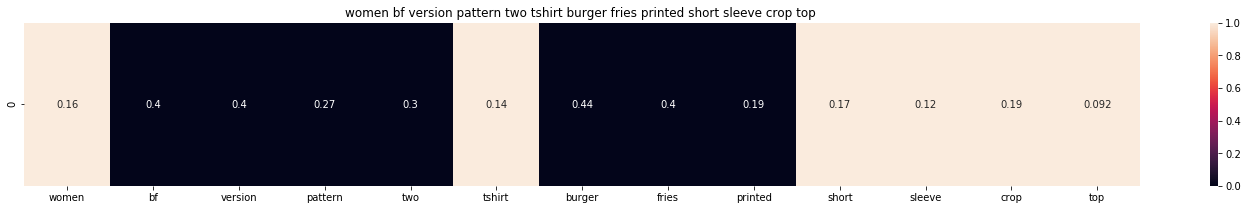

ASIN : B01N0O96XH
Brand : mkp t-shirt
Color : black, white, yellow, red
Type : SHIRT
euclidean distance from input : 0.157459164324
________________________________________________________________________________________________________________________
https://images-na.ssl-images-amazon.com/images/I/41oIZQWH9VL._SL160_.jpg


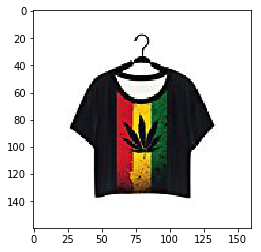

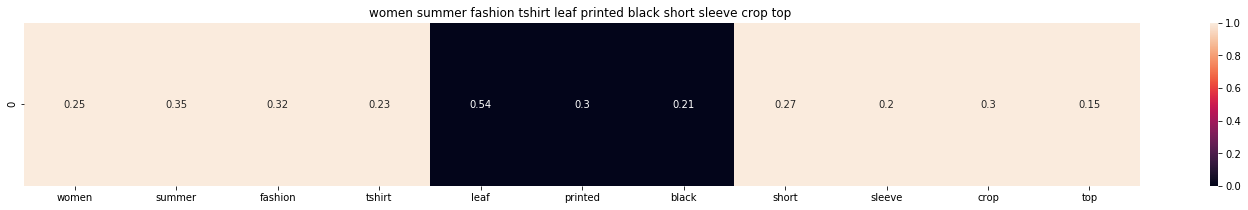

ASIN : B014F2210K
Brand : mkp t-shirt
Color : black, white, yellow, red, green
Type : SHIRT
euclidean distance from input : 0.181818181818
________________________________________________________________________________________________________________________


In [184]:
displayProductDetails(data, itemIndex)
weightedTfIdfWord2vec(itemIndex, numberOfRecommendations, textWeight, brandWeight, typeWeight, colorWeight)

## Image based Product Similarity

In [ ]:
# https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = '16k_images/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

In [73]:
bottleneck_features_train = np.load('data_cnn_features.npy')
asins = np.load('data_cnn_feature_asins.npy')

In [74]:
data = pd.read_pickle('data_preprocessed')
asinsList = list(data['Asin'])
asins = list(asins)

ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title             bcx womens womens juniors sleeveless embroider...
Name: 15901, dtype: object


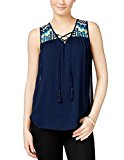

Product Title:  bcx womens womens juniors sleeveless embroidered navy medium 
Euclidean Distance from input image: 0.0
Amazon Url:B07257MP15
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title             lacademie womens velvet vneck cami tank top sz...
Name: 8867, dtype: object


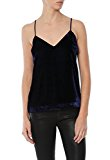

Product Title:  lacademie womens velvet vneck cami tank top sz xs navy 270851dh 
Euclidean Distance from input image: 39.2817
Amazon Url:B073X92S5R
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title                 haute hippie womens casino silk blouse black 
Name: 10682, dtype: object


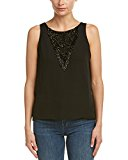

Product Title:  haute hippie womens casino silk blouse black 
Euclidean Distance from input image: 39.7788
Amazon Url:B071JYG85X
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title                    splendid womens double strap cami xl blue 
Name: 3921, dtype: object


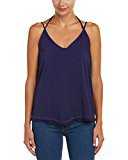

Product Title:  splendid womens double strap cami xl blue 
Euclidean Distance from input image: 39.8176
Amazon Url:B0746STR6M
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title              bar iii womens solid racerback casual top black 
Name: 15989, dtype: object


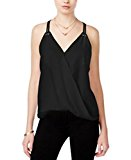

Product Title:  bar iii womens solid racerback casual top black 
Euclidean Distance from input image: 40.1425
Amazon Url:B0724ZCX9F
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title              currentelliott womens smocked raglan top 1 blue 
Name: 13895, dtype: object


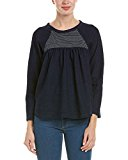

Product Title:  currentelliott womens smocked raglan top 1 blue 
Euclidean Distance from input image: 40.8481
Amazon Url:B0721BLHQH
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title             lacoste womens womens live voile sleeveless na...
Name: 8853, dtype: object


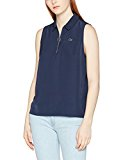

Product Title:  lacoste womens womens live voile sleeveless navy top size navy 
Euclidean Distance from input image: 41.0871
Amazon Url:B01M69QNVH
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title              bar iii womens chiffon pleated casual top green 
Name: 16005, dtype: object


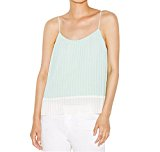

Product Title:  bar iii womens chiffon pleated casual top green 
Euclidean Distance from input image: 41.1022
Amazon Url:B01CDLVBX8
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title             haute hippie womens lets go dancing fringe tan...
Name: 10678, dtype: object


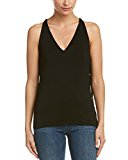

Product Title:  haute hippie womens lets go dancing fringe tank black 
Euclidean Distance from input image: 41.112
Amazon Url:B072M2LT2K
ASIN : MediumImageUrl    https://images-na.ssl-images-amazon.com/images...
Title             vimmia womens vimmia pacific cowl back tank xl...
Name: 2061, dtype: object


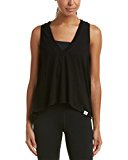

Product Title:  vimmia womens vimmia pacific cowl back tank xl black 
Euclidean Distance from input image: 41.1547
Amazon Url:B0717997RX


In [136]:
from IPython.display import display, Image

def getSimilarProductsBasedOnImage(itemId, num_results):
    itemId  = asins.index(asinsList[itemId])
    pairwiseDisances = pairwise_distances(bottleneck_features_train, bottleneck_features_train[itemId].reshape(1,-1))

    indices = np.argsort(pairwiseDisances.flatten())[0:num_results]
    pdists  = np.sort(pairwiseDisances.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['MediumImageUrl','Title']].loc[data['Asin']==asins[indices[i]]]
        for index, row in rows.iterrows():
            print('ASIN :',row)
            display(Image(url=row['MediumImageUrl'], embed=True))
            print('Product Title: ', row['Title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url:'+ asins[indices[i]])

getSimilarProductsBasedOnImage(527, 10)